In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import random
import sys
from collections.abc import Sequence
from typing import NamedTuple, TypeVar

import numpy as np
import optuna
import torch
import ipywidgets as widgets
from ipywidgets import interact
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from torch import nn, Tensor
from torch.nn import functional as F
from torch.optim import Adam

sys.path.append(os.path.realpath(".."))

from evlp_bronch import lstm
from evlp_bronch.dataset import ALL_LUNG_IDS, ProcessedEVLPDataset
from evlp_bronch.util import get_project_root_dir

# import intel_extension_for_pytorch as ipex

In [3]:
dataset = ProcessedEVLPDataset(ALL_LUNG_IDS)

2023-12-01 02:07:30,502 - evlp_bronch.dataset - INFO - Lung_id 29: Interpolation Dy_comp: between 329 and 331: 142.764474, 157.684626
2023-12-01 02:07:30,528 - evlp_bronch.dataset - INFO - Lung_id 47: Interpolation Dy_comp: between 51 and 56: 50.582276, 72.674668
2023-12-01 02:07:30,540 - evlp_bronch.dataset - INFO - Lung_id 53: Interpolation Dy_comp: between 2813 and 2824: 60.586801, 106.632301


In [4]:
# Train test split according to lung case number
train_lung_ids, test_lung_ids = train_test_split(
    ALL_LUNG_IDS, test_size=2, random_state=0
)
train_lung_ids, val_lung_ids = train_test_split(
    train_lung_ids, test_size=2, random_state=0
)
train_dataset = ProcessedEVLPDataset(train_lung_ids)
val_dataset = ProcessedEVLPDataset(val_lung_ids)
test_dataset = ProcessedEVLPDataset(test_lung_ids)

2023-12-01 02:07:30,665 - evlp_bronch.dataset - INFO - Lung_id 29: Interpolation Dy_comp: between 329 and 331: 142.764474, 157.684626
2023-12-01 02:07:30,689 - evlp_bronch.dataset - INFO - Lung_id 47: Interpolation Dy_comp: between 51 and 56: 50.582276, 72.674668
2023-12-01 02:07:30,701 - evlp_bronch.dataset - INFO - Lung_id 53: Interpolation Dy_comp: between 2813 and 2824: 60.586801, 106.632301


In [5]:
T = TypeVar("T")


def rindex(seq: Sequence[T], value: T) -> int:
    """Finds the last occurrence of a value in a sequence."""
    i = seq[::-1].index(value)
    return len(seq) - i - 1

In [6]:
# Override the default device here
PREFERRED_DEVICE: str | torch.device | None = None

In [7]:
def infer_preferred_device(device: str | torch.device | None) -> torch.device:
    if device is not None:
        if not isinstance(device, torch.device):
            device = torch.device(device)
        # print(f"Using device: {device}")
        return device
    if hasattr(torch, "cuda") and torch.cuda.is_available():
        return torch.device("cuda")
    if hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        return torch.device("mps")
    # if torch.xpu.is_available():
    #     # print("Using XPU")
    #     return torch.device("xpu")
    # print("Using CPU")
    return torch.device("cpu")

## Pytorch Encoder-Decoder

In [8]:
class LSTMSeq2SeqHParams(NamedTuple):
    num_epochs: int
    hidden_size: int
    num_layers: int = 1
    lr: float = 1e-3
    teacher_forcing_ratio: float = 0.0
    inout_dtype: str | np.dtype = np.float32
    device: str | torch.device | None = None

### Preprocessing

In [9]:
def preprocess_no_padding(
    dataset: ProcessedEVLPDataset,
    inout_dtype: str | np.dtype = np.float32,
    device: str | torch.device | None = None,
) -> list[tuple[Tensor, Tensor]]:
    device = infer_preferred_device(device)
    data = []

    for element in dataset:
        # Find the last bronch
        metric_start = rindex(list(element["Is_bronch"]), 1)
        changes = np.where(np.diff(element["Is_assessment"]) == 1)[0]
        last_assessment_start = (
            changes[-1] + 1 if len(changes) > 0 else len(element["Is_assessment"]) - 1
        )
        if metric_start < (len(element["Is_assessment"]) - 1) * 0:
            continue
        if metric_start > last_assessment_start:
            last_assessment_start = len(element["Is_assessment"]) - 1
        # Stack things together
        input_range = slice(None, metric_start + 1)
        X = np.stack(
            [
                element["Dy_comp"][input_range],
                element["Is_normal"][input_range],
                element["Is_assessment"][input_range],
                element["Is_bronch"][input_range],
            ],
            axis=1,
        )
        output_range = slice(metric_start + 5, last_assessment_start)
        Y = np.stack(
            [
                element["Dy_comp"][output_range],
                element["Is_normal"][output_range],
                element["Is_assessment"][output_range],
                element["Is_bronch"][output_range],
            ],
            axis=1,
        )
        if X.shape[0] < 10 or Y.shape[0] == 0:
            continue
        X_tensor = torch.from_numpy(X.astype(inout_dtype)).to(device)
        Y_tensor = torch.from_numpy(Y.astype(inout_dtype)).to(device)
        data.append((X_tensor, Y_tensor))

    return data

In [10]:
train_data = preprocess_no_padding(train_dataset, device=PREFERRED_DEVICE)
val_data = preprocess_no_padding(val_dataset, device=PREFERRED_DEVICE)
test_data = preprocess_no_padding(test_dataset, device=PREFERRED_DEVICE)

### Training

In [11]:
def train_eval_loop(
    hparams: LSTMSeq2SeqHParams,
    verbose: bool = True,
) -> tuple[lstm.Seq2Seq, list[float], list[float]]:
    device = infer_preferred_device(hparams.device)
    seq2seq = lstm.Seq2Seq(
        lstm.EncoderLSTM(hparams.hidden_size, hparams.num_layers),
        lstm.DecoderLSTM(hparams.hidden_size, hparams.num_layers),
    ).to(device)
    optimizer = Adam(seq2seq.parameters(), lr=hparams.lr)
    # if device == torch.device("xpu"):
    #     seq2seq, optimizer = ipex.optimize(model=seq2seq, optimizer=optimizer)
    loss_function = nn.MSELoss()

    losses_train = []
    losses_val = []
    for epoch in range(hparams.num_epochs):
        running_losses_train = []
        seq2seq.train()
        for input, target in random.sample(train_data, k=len(train_data)):
            output = seq2seq(input, target, hparams.teacher_forcing_ratio)
            optimizer.zero_grad()
            output_dy_comp = output[:, 0]
            target_dy_comp = target[:, 0]
            loss = loss_function(output_dy_comp, target_dy_comp)
            loss.backward()
            optimizer.step()
            running_losses_train.append(loss.item())
        mean_loss_train = np.mean(running_losses_train)
        losses_train.append(mean_loss_train)

        # Get prediction val
        with torch.no_grad():
            running_losses_val = []
            seq2seq.eval()
            for input, target in val_data:
                output = seq2seq(input, target, 0)
                output_dy_comp = output[:, 0]
                target_dy_comp = target[:, 0]
                loss = loss_function(output_dy_comp, target_dy_comp)
                running_losses_val.append(loss.item())
        mean_loss_val = np.mean(running_losses_val)
        losses_val.append(mean_loss_val)
        if verbose:
            print(f"Epoch {epoch}: train={mean_loss_train}, val={mean_loss_val}")
    return seq2seq, losses_train, losses_val

In [12]:
seq2seq, losses_train, losses_val = train_eval_loop(
    LSTMSeq2SeqHParams(
        num_epochs=50,
        hidden_size=253,
        num_layers=1,
        lr=0.002,
        teacher_forcing_ratio=0.4641271501763626,
        inout_dtype=np.float32,
        device=PREFERRED_DEVICE,
    )
)

Epoch 0: train=6702.626951054164, val=12920.681640625
Epoch 1: train=3385.05731185845, val=8337.894897460938
Epoch 2: train=1855.8388669592994, val=5718.4537353515625
Epoch 3: train=1227.4569059576306, val=4291.1865234375
Epoch 4: train=997.0229823776654, val=3543.9747924804688
Epoch 5: train=929.8635460193668, val=3143.8712158203125
Epoch 6: train=906.6263270190784, val=3113.5396728515625
Epoch 7: train=901.5423758540835, val=3205.7359008789062
Epoch 8: train=894.5383509159088, val=2984.8672790527344
Epoch 9: train=883.4342603462082, val=3259.966339111328
Epoch 10: train=871.2802817902394, val=3122.701171875
Epoch 11: train=835.720814207622, val=3324.1668395996094
Epoch 12: train=561.653004781689, val=2329.7086791992188
Epoch 13: train=392.6928562768868, val=1739.9488983154297
Epoch 14: train=297.69203249684404, val=1366.275245666504
Epoch 15: train=260.55810583233836, val=1028.9087295532227
Epoch 16: train=201.80610326869146, val=1380.9712600708008
Epoch 17: train=184.6986586017268, 

Text(0.5, 1.0, 'Training Curve for LSTM Seq2Seq')

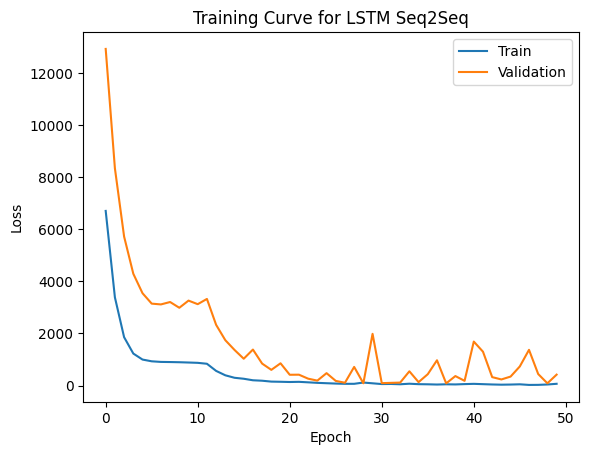

In [20]:
plt.plot(losses_train, label="Train")
plt.plot(losses_val, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training Curve for LSTM Seq2Seq")

In [21]:
split_to_targets_and_outputs = {"train": [], "val": [], "test": []}

with torch.no_grad():
    for split_name, split_data in (
        ("train", train_data),
        ("val", val_data),
        ("test", test_data),
    ):
        for input, target in split_data:
            output = seq2seq(input, target, 0)
            split_to_targets_and_outputs[split_name].append(
                (target.cpu().numpy(), output.cpu().numpy())
            )

### Plots

In [22]:
def plot_forecasting(
    index: int, targets_and_outputs: list[tuple[np.ndarray, np.ndarray]]
) -> None:
    target, output = targets_and_outputs[index]
    output_dy_comp = output[:, 0]
    target_dy_comp = target[:, 0]
    plt.plot(output_dy_comp, label="Output")
    plt.plot(target_dy_comp, label="Target")
    plt.legend()
    plt.xlabel("Breath number")
    plt.ylabel("Dynamic compliance")
    plt.title(f"Forecasting for index {index}")

In [23]:
interact(
    plot_forecasting,
    index=widgets.IntSlider(
        value=100,
        min=0,
        max=len(split_to_targets_and_outputs["train"]) - 1,
    ),
    targets_and_outputs=widgets.fixed(split_to_targets_and_outputs["train"]),
)

interactive(children=(IntSlider(value=100, description='index', max=139), Output()), _dom_classes=('widget-int…

<function __main__.plot_forecasting(index: int, targets_and_outputs: list[tuple[numpy.ndarray, numpy.ndarray]]) -> None>

In [24]:
interact(
    plot_forecasting,
    index=widgets.IntSlider(
        value=3,
        min=0,
        max=len(split_to_targets_and_outputs["test"]) - 1,
    ),
    targets_and_outputs=widgets.fixed(split_to_targets_and_outputs["test"]),
)

interactive(children=(IntSlider(value=3, description='index', max=3), Output()), _dom_classes=('widget-interac…

<function __main__.plot_forecasting(index: int, targets_and_outputs: list[tuple[numpy.ndarray, numpy.ndarray]]) -> None>

### Hyperparameter Tuning

In [25]:
def objective(trial: optuna.Trial) -> float:
    hparams = LSTMSeq2SeqHParams(
        num_epochs=32,
        hidden_size=trial.suggest_int("hidden_size", 32, 256, log=True),
        num_layers=trial.suggest_int("num_layers", 1, 3),
        lr=trial.suggest_float("lr", 1e-4, 1e-2, log=True),
        teacher_forcing_ratio=trial.suggest_float("teacher_forcing_ratio", 0.1, 0.9),
        inout_dtype=np.float32,
        device=PREFERRED_DEVICE,
    )
    _, losses_train, losses_val = train_eval_loop(hparams, verbose=False)
    losses = sorted(losses_train + losses_val)
    return np.mean(losses[: min(5, len(losses))])

In [26]:
name = "20231130_lstm_v2"
storage = optuna.storages.JournalStorage(
    optuna.storages.JournalFileStorage(
        os.fspath(get_project_root_dir() / "tuning" / f"{name}.log")
    )
)

study = optuna.create_study(storage=storage, study_name=name, direction="minimize")
study = optuna.load_study(study_name=name, storage=storage)

/tmp/ipykernel_1071824/3967608439.py:2: ExperimentalWarning: JournalStorage is experimental (supported from v3.1.0). The interface can change in the future.
  storage = optuna.storages.JournalStorage(


DuplicatedStudyError: Another study with name '20231130_lstm_v2' already exists. Please specify a different name, or reuse the existing one by setting `load_if_exists` (for Python API) or `--skip-if-exists` flag (for CLI).

In [ ]:
study.optimize(objective, n_trials=128)